In [1]:
#Importamos librerias
import pandas as pd
import numpy as np
import matplotlib as mpl
import seaborn as sns
pd.options.display.max_rows = 30
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline

In [16]:
#Importamos la base de datos
properati = pd.read_csv("properati.csv")

In [17]:
#Como todas las filas en "operation" son ventas, 
#la columna no añade informacion, por lo que se remueve
properati = properati.drop(columns="operation")

In [39]:
properati = properati[properati.price_usd_per_m2 < 8000]

properati = properati[properati.price_usd_per_m2 > 500]

properati = properati[properati.surface_covered_in_m2 < 600]

properati = properati[properati.surface_covered_in_m2 > 30]

properati = properati[properati.surface_total_in_m2 > 30]

properati = properati[properati.surface_total_in_m2 < 1000]

properati.shape

(53056, 25)

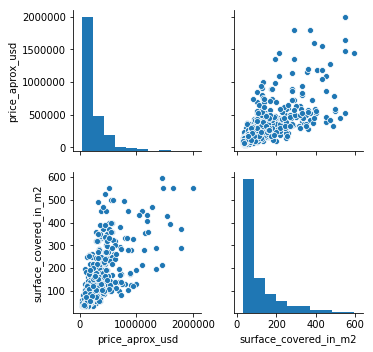

In [40]:
sns.pairplot(properati[["price_aprox_usd","surface_covered_in_m2"]].sample(800))


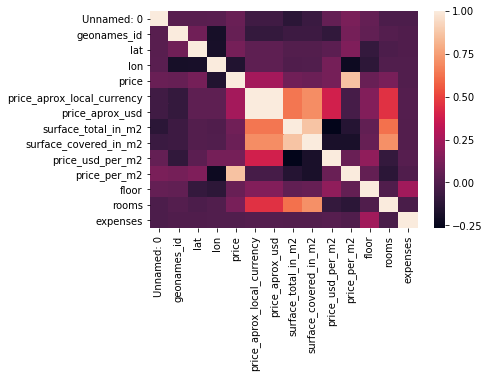

In [41]:
sns.heatmap(properati.corr())